# Binary Classification of Coding and Noncoding Genes in Prokaryotic Genomes

## Introduction

This project was based on the 2008 paper ['Gene prediction in metagenomic fragments: A large scale machine learning approach'](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-9-217) by Hoff et at. The goal of this notebook is to train the gene prediction algorithm using a 2-stage approach - linear discriminant and neural network. The linear discriminant model reduces high dimensional features and the neural network predicts if a given sequence is a gene or not. My intentions for starting this project were to gain a deeper understanding of machine learning approaches behind the `Orphelia gene prediction algorithm` and sharpen my programming skills. 

See the `examples` folder for example code.
       
## Background
Genes are structured sequences of DNA that code for proteins. They begin with a start codon - ATG, CTG, GTG, or TTG - and end with an in-frame stop codon - TAG, TGA, or TAA. Noncoding sequences are sequences found in intergenic regions (space between genes) of the genome that also start with a start codon and end with an in-frame stop codon; however, these sequences do not code for proteins. 

Rather than training a predictive algorithm on the sequence itself, meaningful features can be extracted from genes to better determine if a given sequence is a gene or not. These features include `monocodon (tricodon) usage`, `dicodon (hexcodon) usage`, `translation initiation sites (TIS)`, and `GC` content. 

However, the first three features mentioned above contain a lot of information (high diminsionality), and therefore need to be dimensionally reduced. This is done by training a linear discriminant (or weights of a linear regression model) to reduce each of those features into a single value. 

Lastly, with the extracted/reduced features, a binary neural network can be trained to predict if a given sequence codes for a protein (gene) or not. 

## Content
1. Preprocess Genome 
    * extract coding sequences (genes) and noncoding sequences, 
    * shuffle and split data
2. Extract High Dimensional Features
    * monocodon (tricodon) frequency, 
    * dicodon (hexcodon) frequency, 
    * translation initiation site (TIS)
3. Train Linear Discriminant For Dimentional Reduction 
4. Train Binary Neural Network for Gene Prediction

# Google Colab Setup

First clone the `gene-prediction` repository to Google Colab (see setup in `README.md`). Then install dependencies (see code below).

In [ ]:
# Install dependencies
!pip install -r requirements.txt

# Install biopython library manually
!pip3 install biopython

# Pull latest code
!git pull

# Import Packages

In [1]:
# Enter your email for the Entrez API 
email = "vignesh.ravindranath@gmail.com"

In [2]:
import os
import sys
import numpy as np
from scipy.sparse import csr_matrix
from Bio import Entrez
Entrez.email = email

# will inform your notebook to actively reload all 
# imported modules and packages as they are modified
%load_ext autoreload
%autoreload

# self defined functions
from preprocess import preprocess_genome
from fe import extract_features, extract_tis_training_feature, populate_codon_idx_dict
from ld import train_linear_discriminant, prior_gaussian, X3, X4

2021-09-06 02:03:59.375557: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64
2021-09-06 02:03:59.375645: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Preprocess Genome

## Extract Positive/Negative ORFs
Preprocessing a genome consists of finding all valid open reading frames (ORFs). ORFs start with a start codon (ATG, CTG, GTG, or TGT) and end with an in-frame stop codon (TAG, TGA, or TAA). To train our neural network, we need to find positive ORFs - sequencies that code for a protein (i.e. genes) -  and negative ORFs - sequencies in the genome that start with a start codon and end with an in-frame stop codon, but don't code for a protein. The negative ORFs can be found in the interregions of a genome or space between genes. 

For this project, positive ORFs will be referred to as CDS or **C**o**D**ing **S**equences, and negative ORFs will be referred to as NCS or **N**on **C**oding **S**equences.

In [3]:
# preprocess_genome takes an input TEXT file of 
# GenBank accession numbers from the `inputs` folder.
#
# See the `inputs` folder for examples. You can add 
# your own input text file with unique accession 
# numbers for preprocessing

%time _cds, _ncs = preprocess_genome('input_test.txt')

Successfully fetched NC_000917
2478 CDS Records, 950 NCS Records

Successfully fetched NC_003305
1876 CDS Records, 892 NCS Records

Successfully fetched NC_004842
955 CDS Records, 578 NCS Records

5309 Total CDS Records
2420 Total NCS Records
CPU times: user 1min 56s, sys: 1.16 s, total: 1min 57s
Wall time: 2min 53s


In [4]:
print(f'{sys.getsizeof(_cds) / 1000} kB')
print(f'{sys.getsizeof(_ncs) / 1000} kB')

47.88 kB
21.88 kB


### Biopython SeqRecord Structure Examples

The CDS and NCS data above are lists of Biopython **SeqRecord** that contain information about each sequence, such as `ID`, `Name`, `Description`, `Number of features`, and `Seq`.

* `ID` is the GenBank accession number for the prokaryotic genome the sequence was extracted from. 
* `Name` is a auto-generated identifier that the program creates for each sequence. 
* `Description` is blank. 
* `Number of features` includes another Biopython data structure called **SeqFeature** that contains information about the type (CDS or NCS), start location on the genome, the stop location on the genome, and what strand the gene originated from - (+) if it came from the template strand and (-) if it came from the coding strand. 
* `Seq` is another Biopython object that contains the sequence of the gene. 

**NOTE**: the sequence contains a buffer of *30 basepairs upstream of the start codon* and *30 basepairs downstream of the stop codon*. The additional information is necessary to extract the TIS feature.

In [8]:
print(_cds[0])

ID: NC_000917
Name: AF_RS09825
Description: <unknown description>
Number of features: 1
Seq('TTTTAATTTTTTAAGTTCGCAGAACACTCCATGAATGTTGGATATCTCTGCACT...GAA')


In [15]:
# to view individual attributes by themselves
print(_cds[0].id)
print(_cds[0].name)
print(_cds[0].description)
print(_cds[0].features[0])
print(_cds[0].seq[30:-30])

NC_000917
AF_RS09825
<unknown description>
type: CDS
location: [1759795:1760785](+)
qualifiers:

ATGAATGTTGGATATCTCTGCACTTACACTCCAAAAGAGCTTATCGACGCTGCGGGCTTCACACCAATAAGGATTTTTGCTGGTGACATGCAAATCAGCCTCGCCACAGCACATATTCAGAGTTACGCCTGCTCTCAGGCAAGGGGGAGCCTTGAGAGGGCTCTAAGAGGAGAGCTAGATGTTCAGGCGGTTGTTTTCACGAGGTGCTGCGACACTCTCATGCGATTAGCCGACATCTGGGAGAGAAACACAGATATGAGAGTTTACAACATCGAATTCCCCACGAGGGTTGAGGAGAGAAGCAAGGATTACTACTTCAACGAGCTCAAGGACTTCGTCAAAGTTCTCGAAGAGTGGGGCGGTGGTGTTACACTCGAGAGTTTGAGGGAGAGTCTAAAACTTTATCACGAGCTTGAAGAGAAGCTTAAAAGGCTTTTCAGCCTCAAGCCTGACTACGAAGCAGCAAAGAGAGTTCAGGAGATGAATGTAAGAGAAGCGATAAAGTTCGTGGATGAGAGGCTGCGAAAAGCTGAAAGCGAAGGTGGAAAACCGAGGGTTCTGATTACCGGAAGCGTGTGTCCCTTTGTGGAAGTTTACACTCTGTTCGAGGAGGCGGGTTTTGCCCTTAAAGACGACATCTGCACGGGAACGAGGTTCTTCACCTTCAACACACCGCCGAGAGAAATAGGGTCGGTTGATGAGGGGTTGAGGTTTCTGGTGGACAAGTACTTTGAAAAAGCCCCCTGCCCGACGAAGCACTTCCCAAATGACGATAGATTCAAATATATCCTTGAAATGGCCAAGGATTGCGACGGGGTTGTGTTCCTGCTGCTCAAGTTCTGCGAGCCGCACTTCTACGATTACCCGCAGCTTAAAGAGAGGCTTGAAGAGATGGGCAAGAAA

## Shuffle and Split Data

The data collected (CDS and NCS records) will be randomized and split into two even parts - one half for training the linear discriminant and the other for training the neural network. Since the TIS linear discriminant only relies on CDS records, it will contain the same CDS records that are in the codon linear discriminant dataset (`LD_Cod_Data`). 

In [4]:
import random
random.seed(8)
random.shuffle(_cds)
random.shuffle(_ncs)

for i in range(5):
    print(_cds[i].name, _ncs[i].name)

AF_RS09825 AC_NC01145
AF_RS10255 AF_NC01968
ACIAD_RS10625 AC_NC00556
AF_RS09165 AC_NC02391
ACIAD_RS13690 AC_NC03024


In [5]:
a = int(len(_cds)/2)
b = int(len(_ncs)/2)

LD_Tis_Data = _cds[0:a]
LD_Cod_Data = _cds[0:a] + _ncs[0:b]
NN_Data = _cds[a:] + _ncs[b:]

print(f'LD Dataset: {len(LD_Tis_Data)}')
print(f'LD Dataset: {len(LD_Cod_Data)}')
print(f'NN Dataset: {len(NN_Data)}')

LD Dataset: 2859
LD Dataset: 4212
NN Dataset: 4214


# Extract Features

## Extract Codon and TIS Features for LD Training

The neural network won't be taking an entire ORF sequence as an input. Rather, we will first extract important features and train the neural network on those features. Important features include codon frequency (ex. ATGCCC... => 'ATG', 'CCC', ...) and translation initiation sites (tis). For codon frequency we can extract monocodon usage (what are all the codons in the sequence) and dicodon usage (what are all the dicodons in the sequence; ex. ATGCCCTTTGGG... => 'ATGCCC', 'TTTGGG', ...). Tis usually occur upstream of the start codon for a codon sequence (gene). So, for the tis feature, we will extract a frame that looks at 30 basepairs (bp) upstream and downstream of start codons (see heatmap below).

In [6]:
# features: tri, hex, tis_nn, gc, y
%time LD_tri, LD_hex, _, _, LD_yc = extract_features(LD_Cod_Data, train_nn=False)

# tis features: tis, yt
%time LD_tis, LD_yt = extract_tis_training_feature(LD_Tis_Data)

CPU times: user 15.2 s, sys: 438 ms, total: 15.6 s
Wall time: 15.8 s
CPU times: user 15.1 s, sys: 6.47 s, total: 21.6 s
Wall time: 21.8 s


# Train Linear Discriminant for Dimensional Reduction

We need to minimize:

$$ E(w_M) = \frac{1}{n}\sum_{i=0}^{n}(w_m \cdot x_M^i - y_i)^2 + \lambda w_M \cdot w_M $$

where $x_M^i \in \mathbb{R}^{64}$ is the $i-th$ column of the monocodon frequency matrix $\textbf{X}_M$, $n=64$ monocodon possibilities, $y_M^i \in (-1, 1)$ is the $i-th$ element of the label vector, and $w_M$ is the discriminant weight vector.

We can minimize $E$ by:

$$w_M = (X_MX_M^T +\lambda n\textbf{I})^{-1}X_My_M$$

This can be generalized to train the discriminant vector $w$ for dicodon frequency and TIS. 

In [7]:
# train weight vectors - csr_matrix (sparse row matrix) is used to speed up calculation/reduce space of data 
%time wM = train_linear_discriminant(csr_matrix(LD_tri), LD_yc) # monocodon (tri)
%time wD = train_linear_discriminant(csr_matrix(LD_hex), LD_yc) # dicodon (hex)
%time wT = train_linear_discriminant(csr_matrix(LD_tis), LD_yt) # tis

print(wM.shape, wD.shape, wT.shape)

CPU times: user 109 ms, sys: 31.2 ms, total: 141 ms
Wall time: 143 ms
CPU times: user 20.8 s, sys: 2.19 s, total: 23 s
Wall time: 15.5 s
CPU times: user 41.1 s, sys: 8.41 s, total: 49.5 s
Wall time: 40.9 s
(64,) (4096,) (3712,)


## Visualizing TIS Patterns

Loaded data from ./data/weights.


<AxesSubplot:>

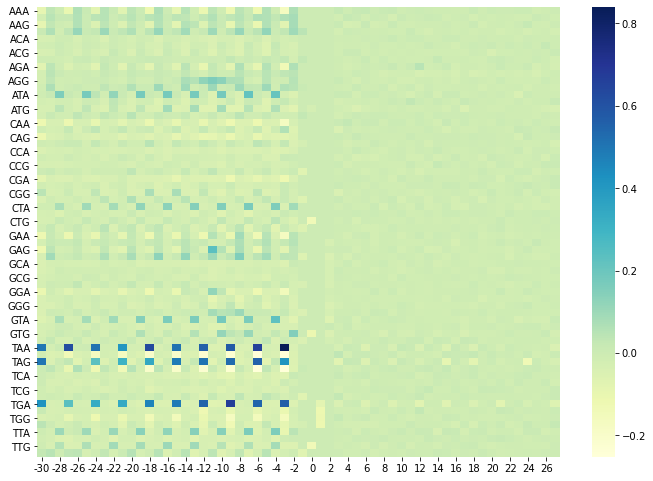

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

w = np.array(wT).reshape(58,64).T

y_axis_labels = populate_codon_idx_dict(nbases=3).keys()
x_axis_labels = [i for i in range(-30,28)]

df = pd.DataFrame(w, columns=x_axis_labels, index=y_axis_labels)

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(ax=ax, data=df, cmap="YlGnBu")

The heatmap represents the weight vector wT of the TIS linear discriminant. So, if wT is a 2D array

$$
\begin{bmatrix}
w_{1,1} & ... & w_{1,58} \\
& \ddots &  \\
w_{64,1} & ... & w_{64,58}
\end{bmatrix}
$$

then we predict if a given sequence is a gene or not by computing the TIS linear regression

$$y = w_{1,1} \cdot AAA_{-30} + ... + w_{1,64} \cdot AAA_28 + ... + w_{64,1} \cdot TTT_{-30} + ... + w_{64,58} \cdot TTT_{28}$$

where y is -1 (not a gene) or 1 (is a gene). The weights are multiplied by a value 0 or 1 depending on if the codon is present at the position relative to the start codon. For example if $AAA_{-30} = 1$, then at the $-30^{th}$ frame you will find the codon $AAA$. 

These weight values do not represent the occurrences of the codons, rather they represent the importance of those codons for predicting if a given sequence is a gene or not. 
- If a particular weight value is <0, the codon at that particular position is commonly seen in sequences that are not genes (makes y more negative). 
- If a particular weight value is 0, the codon at that particular position does not help in predicting if a given sequence is a gene or not. 
- If a particular weight value is >0, the codon at that particular position is commonly seen in sequences that are genes (makes y more positive). 

So based on the heatmap, it looks like the stop codons (TAA, TAG, and TGA) upstream of the start codon are more important in determining if a given sequence is a gene or not. Also, the squares for each of the 4 start codons at the 0th position are weighted around between 0.0 and -0.2, indicating they are not too important for predicting if a given sequence is a gene or not (which makes sense since all sequences - CDS and NCS - have the same start codons). 

## Find Gaussian Distributions for Postive/Negative TIS Features

Ideally, input sequences into the prediction algorithm will contain all the information we need to determine if the sequence is a gene or not. However, next-generation sequencing (NGS) tools often produce fragments of DNA that vary in length from 100 bp to 700 bp. Therefore, the entire TIS region (30 bp upstream of the start codon to 30 bp downstream of the start codon) may not be present in the input sequence. 

To overcome this, a Gaussian distribution can be trained on the training genomes provided. Then, we can predict how likely a given fragment of a TIS window is from a gene or not. 

In [11]:
LD_tis_red = LD_tis @ wT
LD_tis_red.shape

(70029,)

In [12]:
LD_tis_pos = []
LD_tis_neg = []

for element in zip(LD_tis_red, LD_yt):
    if element[1] == 1:
        LD_tis_pos.append(element[0])
    else:
        LD_tis_neg.append(element[0])
        
print(len(LD_tis_pos), len(LD_tis_neg))

2856 67173


In [13]:
pi, mu, sd = prior_gaussian(LD_tis_pos, LD_tis_neg)

print(pi)
print(mu)
print(sd)

Saved data to ./data/tis-stats.
[0.040783104142569505, 0.9592168958574305]
[0.03857002227914169, -0.9591166585647091]
[0.6239910585623043, 0.15505792862395792]


In [14]:
# test gaussian distribution output on known sequence
pos_test = LD_tis_pos[1]
neg_test = LD_tis_neg[1]
print(pos_test, neg_test)

print(X3(pos_test, pi, mu, sd))
print(X4(pos_test, pi, mu, sd))

0.7795583050319752 -1.0162752548855885
1.0
9.545193701309249e-26


# Train Neural Network for Gene Prediction

In [16]:
from keras.models import Sequential
from keras.layers import Dense

## Extract Codon and TIS Features

In [19]:
# features: tri, hex, tis_nn, gc, y
%time NN_tri, NN_hex, NN_tis, NN_gc, NN_y = extract_codon_tis_features(NN_Data, train_nn=True)

CPU times: user 19.6 s, sys: 516 ms, total: 20.1 s
Wall time: 20.5 s
Saved data to ./data/NNFE.


## Reduce Feature Dimensions

In [21]:
x1 = NN_tri @ wM
x2 = NN_hex @ wD 
x3 = X3(NN_tis @ wT, pi, mu, sd)
x4 = X4(NN_tis @ wT, pi, mu, sd)
x7 = NN_gc
y  = NN_y

print(x1.shape, x2.shape, x3.shape, x4.shape, x7.shape, y.shape)

(4208,) (4208,) (4208,) (4208,) (4208,) (4208,)


## Shuffle and Split Data

In [22]:
nn_data = np.stack((x1,x2,x3,x4,x7,y)).T

random.seed(8)
random.shuffle(nn_data)

X = nn_data[:, :-1]
y = nn_data[:, -1]

print(X.shape, y.shape)

(4208, 5) (4208,)


In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

## Define Model

In [25]:
model = Sequential()
model.add(Dense(25, input_dim=5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

2021-08-21 15:33:09.372839: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-21 15:33:09.388168: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2592000000 Hz
2021-08-21 15:33:09.391935: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fffdcfb7bf0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-08-21 15:33:09.392046: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [26]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64)

Epoch 1/100
40/40 [==============================] - 0s 1ms/step - loss: 0.5769 - accuracy: 0.8910
Epoch 2/100
40/40 [==============================] - 0s 1ms/step - loss: 0.3392 - accuracy: 0.9410
Epoch 3/100
40/40 [==============================] - 0s 1ms/step - loss: 0.2025 - accuracy: 0.9406
Epoch 4/100
40/40 [==============================] - 0s 1ms/step - loss: 0.1148 - accuracy: 0.9402
Epoch 5/100
40/40 [==============================] - 0s 1ms/step - loss: 0.0499 - accuracy: 0.9382
Epoch 6/100
40/40 [==============================] - 0s 1ms/step - loss: -0.0062 - accuracy: 0.9362
Epoch 7/100
40/40 [==============================] - 0s 1ms/step - loss: -0.0553 - accuracy: 0.9354
Epoch 8/100
40/40 [==============================] - 0s 1ms/step - loss: -0.1046 - accuracy: 0.9334
Epoch 9/100
40/40 [==============================] - 0s 1ms/step - loss: -0.1539 - accuracy: 0.9330
Epoch 10/100
40/40 [==============================] - 0s 1ms/step - loss: -0.2074 - accuracy: 0.9326
Epoc

## Save Model

In [ ]:
# TODO

In [30]:
y_pred = model.predict(X_test)

#Converting predictions to label
pred = []
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))

#Converting one hot encoded test label to label
test = []
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))